<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Práctica" data-toc-modified-id="Práctica-1">Práctica</a></span><ul class="toc-item"><li><span><a href="#Regresión-con-PySpark" data-toc-modified-id="Regresión-con-PySpark-1.1">Regresión con PySpark</a></span></li></ul></li><li><span><a href="#Problema" data-toc-modified-id="Problema-2">Problema</a></span><ul class="toc-item"><li><span><a href="#Estrategia" data-toc-modified-id="Estrategia-2.1">Estrategia</a></span></li><li><span><a href="#Pasos-a-seguir" data-toc-modified-id="Pasos-a-seguir-2.2">Pasos a seguir</a></span></li><li><span><a href="#Preparando-el-entorno" data-toc-modified-id="Preparando-el-entorno-2.3">Preparando el entorno</a></span></li><li><span><a href="#Carga-de-datos" data-toc-modified-id="Carga-de-datos-2.4">Carga de datos</a></span></li><li><span><a href="#Análisis-exploratorio" data-toc-modified-id="Análisis-exploratorio-2.5">Análisis exploratorio</a></span><ul class="toc-item"><li><span><a href="#Análisis-de-nulos" data-toc-modified-id="Análisis-de-nulos-2.5.1">Análisis de nulos</a></span></li><li><span><a href="#Borrado-de-columnas-con-muchos-nulos" data-toc-modified-id="Borrado-de-columnas-con-muchos-nulos-2.5.2">Borrado de columnas con muchos nulos</a></span></li><li><span><a href="#Tipos-de-datos" data-toc-modified-id="Tipos-de-datos-2.5.3">Tipos de datos</a></span><ul class="toc-item"><li><span><a href="#Transformación-de-características" data-toc-modified-id="Transformación-de-características-2.5.3.1">Transformación de características</a></span></li><li><span><a href="#La-variable--recent_trend" data-toc-modified-id="La-variable--recent_trend-2.5.3.2">La variable  <code>recent_trend</code></a></span></li><li><span><a href="#Resto-de-variables" data-toc-modified-id="Resto-de-variables-2.5.3.3">Resto de variables</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Creación-de-modelos-y-comparación" data-toc-modified-id="Creación-de-modelos-y-comparación-3">Creación de modelos y comparación</a></span></li></ul></div>

# Práctica

## Regresión con PySpark

In [1]:
# Curso: TDM - 2022/2023
# Nombre:
# Apellidos:
# Fecha:

- Se valorará la claridad del código y evitar redundancias o código poco eficiente. 
- Además de las funciones que se piden se pueden añadir otras auxiliares si se necesitan, y también otros imports
- El código debe funcionar correctamente no solo con las pruebas que vienen de ejemplo sino con cualquier otra prueba




# Problema

Disponemos de datos de salud para poblaciones de EEUU. Queremos saber si los 
grupos de bajos ingresos tienen mayor riesgo de ser diagnosticados y morir de cáncer (cancer del pulmón). 

## Estrategia

El gobierno de EEUU ha publicado datos abiertos con los que vamos a trabajar. Se trata de datos sobre incidencia y mortalidad del cáncer. También otros datos sobre la Comunidad Estadounidense con una multitud de variables adicionales que podemos optar por incluir en nuestro modelo.


## Pasos a seguir

1. Limpieza y preparación de los datos
2. Análisis exploratorio
3. Modelo estadístico
4. Visualizaciones


## Preparando el entorno

In [2]:
import os.path
from subprocess import check_call
import importlib
import urllib
import os
import sys

modules = ["findspark","pyspark","urllib","pyspark_dist_explore"]

if 'google.colab' in sys.modules:
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    spark = "spark-3.2.0-bin-hadoop3.2.tgz"
    if not os.path.isfile(spark):
        !wget -q https://downloads.apache.org/spark/spark-3.2.0/{spark}
        !tar xf {spark}
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
        os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

print("Checking required modules")
for m in modules:
    torch_loader = importlib.util.find_spec(m)
    if torch_loader is not None:
        print(m," found")
    else:
        print(m," not found, installing")
        if 'google.colab' in sys.modules:
            check_call(["pip", "install", "-q", m])
        else:
            check_call([sys.executable, "-m", "pip", "install", "--user", m])
print("Done!")

Checking required modules
findspark  found
pyspark  found
urllib  found
pyspark_dist_explore  found
Done!


In [3]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

import findspark
findspark.init()

import pyspark                         # only run after findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as f


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext                        # para trabajar con RDD's

df = spark.sql('''select 'spark' as hola ''')
df.show()

23/11/22 17:20:35 WARN Utils: Your hostname, danrec-HP-Pavilion-Gaming-Laptop-15-ec0xxx resolves to a loopback address: 127.0.1.1; using 10.8.2.106 instead (on interface wlo1)
23/11/22 17:20:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/22 17:20:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/22 17:20:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
+-----+
| hola|
+-----+
|spark|
+-----+



## Carga de datos

In [6]:
def load_file(file):
    df = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(file)
    return df

In [7]:
# Sol:

def create_spark_dataframe(file):
    df = spark.read.format("com.databricks.spark.csv").options(sep = ';',header='true', inferschema='true').load(file)
    return df

# primero lo descargamos en local
url = "https://raw.githubusercontent.com/ygarciar/Datasets/main/fulldf.csv"
file = "./fulldf.csv"
urllib.request.urlretrieve(url,file)

# ahora llamamos a la función
fulldf = create_spark_dataframe(file)

__Descripción de los datos__


`State` 	, estado	
`AreaName` , área		
`All_Poverty`, 	Both male and female reported below poverty line 	
`M_Poverty` ,	Males below poverty 	
`F_Poverty`, 	Females below poverty 	
`FIPS`, 	State + County FIPS 	
`Med_Income`: Ingreso medio todas las étnias
`Med_Income_White`, Ingreso medio comunidad blanca
`Med_Income_Black`, Ingreso medio comunidad negra
`Med_Income_Nat_Am`, Ingreso medio nativos americanos
`Med_Income_Asian`, Ingreso medio comunidad asiática
`Hispanic`    , Ingreso medio comunidad hispana 	
`M_With`, 	Males with health insurance 	
`M_Without`, 	Males without health insurance 
`F_With`, 	Females with health insurance	
`F_Without`, 	Females without health insurance 	
`All_With`, 	Males and Femaes with health ins. 	
`All_Without`, 	Males an Females without health ins 	
`Incidence_Rate` ,	Lung cancer incidence rate (per 100,000)	'\*' = fewer that 16 reported cases
`Avg_Ann_Incidence` ,	Average lung cancer incidence rate 	
`recent_trend`, 	Recent trend (incidence) 	
`Mortality_Rate` ,	Lung cancer mortality rate (per 100,000) 	'\*' = fewer that 16 reported cases
`Avg_Ann_Deaths`, 	Average lung cancer mortalities 

`POPESTIMATE2015` : Población del estado


Tasas de mortalidad normalizadas: per cápita (100.000)

## Análisis exploratorio

* ¿Cantidad de datos?
* Columnas y sus tipos
* Primeras filas

In [13]:
# Sol:
print((fulldf.count(), len(fulldf.columns)))
fulldf.schema
fulldf.limit(10).show()

(3134, 24)
+-----+--------------------+-----------+---------+---------+----+----------+----------------+----------------+-----------------+----------------+--------+------+---------+------+---------+--------+-----------+--------------+-----------------+------------+--------------+--------------+---------------+
|State|            AreaName|All_Poverty|M_Poverty|F_Poverty|FIPS|Med_Income|Med_Income_White|Med_Income_Black|Med_Income_Nat_Am|Med_Income_Asian|Hispanic|M_With|M_Without|F_With|F_Without|All_With|All_Without|Incidence_Rate|Avg_Ann_Incidence|recent_trend|Mortality_Rate|Avg_Ann_Deaths|POPESTIMATE2015|
+-----+--------------------+-----------+---------+---------+----+----------+----------------+----------------+-----------------+----------------+--------+------+---------+------+---------+--------+-----------+--------------+-----------------+------------+--------------+--------------+---------------+
|   AK|Aleutians East Bo...|        553|      334|      219|2013|   61518.0|       

### Análisis de nulos

Estudiar el número de nulos de cada una de las columnas

In [22]:
# check for null values
# Sol:
import pyspark.sql.functions as F
for col in fulldf.columns:
    print(f"Valores nulos de la columna {col}:{fulldf.where(F.col(col).isNull()).count()}")

Valores nulos de la columna State:0
Valores nulos de la columna AreaName:0
Valores nulos de la columna All_Poverty:0
Valores nulos de la columna M_Poverty:0
Valores nulos de la columna F_Poverty:0
Valores nulos de la columna FIPS:0
Valores nulos de la columna Med_Income:1
Valores nulos de la columna Med_Income_White:2
Valores nulos de la columna Med_Income_Black:1210
Valores nulos de la columna Med_Income_Nat_Am:1660
Valores nulos de la columna Med_Income_Asian:1757
Valores nulos de la columna Hispanic:681
Valores nulos de la columna M_With:0
Valores nulos de la columna M_Without:0
Valores nulos de la columna F_With:0
Valores nulos de la columna F_Without:0
Valores nulos de la columna All_With:0
Valores nulos de la columna All_Without:0
Valores nulos de la columna Incidence_Rate:0
Valores nulos de la columna Avg_Ann_Incidence:0
Valores nulos de la columna recent_trend:0
Valores nulos de la columna Mortality_Rate:0
Valores nulos de la columna Avg_Ann_Deaths:0
Valores nulos de la columna

### Borrado de columnas con muchos nulos

Los datos sobre el ingreso medio por origen étnico están incompletos. Eliminar las columnas con valores nulos excepto la columna `Med_Income`.

In [23]:
# Sol:
for col in fulldf.columns:
    if col != "Med_Income":
        if fulldf.where(F.col(col).isNull()).count()>0:
            fulldf = fulldf.drop(F.col(col))

In [24]:
print((fulldf.count(), len(fulldf.columns)))

(3134, 19)


### Tipos de datos

A continuación, debemos revisar que los datos son numéricos (en lugar de cadenas u otros tipos). Para las columnas `Mortality_Rate`y `Incidence_Rate` hay que tener cuidado (traen asteriscos en algunos casos).

__Calcula el número de * en las columnas `Mortality_Rate`y `Incidence_Rate`__

In [27]:
# Calcula el número de * en la columna Moratality_rate
# Sol:
fulldf.where(F.col("Mortality_Rate").contains("*")).count()

325

Podemos ver que 325 de las muestras de `Mortality_Rate` contienen un asterisco. Podemos ver en la documentación que el asterisco representa una supresión de los datos en los casos en que se informaron menos de 16 casos anuales.

In [28]:
# Calcula el número de * en la columna Incidence_Rate
# Sol:
fulldf.where(F.col("Incidence_Rate").contains("*")).count()

211

Tenemos que tomar una decisión sobre qué hacer con los 325 estados que informaron menos de 16 muertes y a los que les faltan valores de tasa de mortalidad (*).

__Caso 1__ ¿El hecho de que se hayan reportado menos de 16 casos se debe a una mala notificación? En ese caso es posible que deseemos eliminar esas observaciones. O tal vez queramos intentar imputar los valores.

__Caso 2__ Suponemos que los datos son correctos. En ese caso, es posible que deseemos cambiar "\*" a cero, o a un número menor que 16.

__Caso 3__ Si las observaciones son realmente válidas y las eliminamos, entonces agregamos sesgo al modelo.

__Caso 4__ Si las observaciones son ruido, entonces debemos eliminarlas o imputarlas.

Exploremos los datos para fundamentar nuestra decisión.

__Estudio de estados__

* Determina qué estados tienen asteriscos en la columna `Incidence_Rate`. ¿Cuántos valores * hay en cada estado?

* Determina qué estados tienen asteriscos en la columna `Incidence_Rate`. ¿Cuántos valores * hay en cada estado?

In [30]:
# SOL: 
fulldf.where(F.col("Incidence_Rate").contains("*")).groupBy("State").count().show()

+-----+-----+
|State|count|
+-----+-----+
|   OR|    3|
|   VA|    2|
|   WY|    2|
|   MI|    1|
|   ID|   10|
|   CA|    2|
|   NE|   31|
|   MT|   15|
|   MO|    1|
|   ND|   22|
|   WA|    1|
|   MS|    1|
|   NM|    6|
|   SD|   24|
|   TX|   47|
|   GA|    4|
|   CO|   16|
|   AK|    8|
|   OK|    4|
|   UT|   10|
+-----+-----+
only showing top 20 rows



__Dibuja el histograma de las columnas anteriores sin valores con *.__
Antes de dibujar el histograma, los valores han de ser numéricos

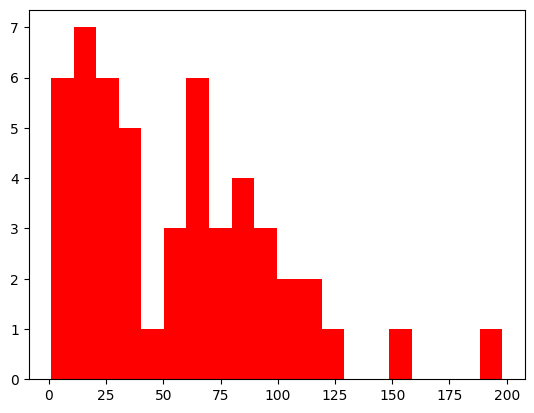

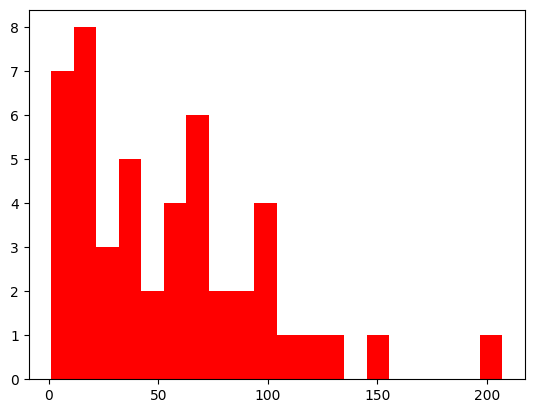

In [48]:
# SOL: 
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

for col in ["Mortality_Rate", "Incidence_Rate"]:
    df_hist = fulldf.select(
        F.col(col).cast("double")
        ,F.col("State")
    ).where(
        ~(F.col(col).contains("*"))
    ).groupBy('State').count()


    fig, ax = plt.subplots()
    hist(ax, df_hist.select("count"), bins = 20, color=['red'])

Si todos los estados con asteriscos tienen poca población, entonces deberíamos tratarlos como válidos y reemplazarlos con un valor bajo (por ejemplo, 8). En caso contrario, entonces deberíamos eliminar esas observaciones.

La información de la cantidad de población se recoge en el campo: `POPESTIMATE2015`.

__Estudiar si los estados con asteriscos en  `Mortality_Rate` tienen una población baja__.
Calcula la media de población de:
* estados con *
* estados sin *
* todos los estados

In [210]:
# SOL:

# estados sin asteriscos
 
# estados con asteriscos
 
# media de todos
 

113930.30829476682 3917.7784615384617 102521.86151882578


En los resultados deberías obtener que los estados que reportan asteriscos  tienen menos población que los que no los tienen. Tal vez por eso tienen menos de 16 casos (por cada 100.000).

Pero... Vamos a ver la media de la tasa de mortaliadd de los estados por cantidad de población.

<!--Pero todavía no estoy convencido de que debamos confiar en que en realidad no tuvieron mortalidad por cáncer de pulmón. Sospecho que es menos probable que los condados con baja población mantengan y reporten buenos datos. Examinemos más a fondo.
-->
Calcula la tasa de mortalidad de los estados con población en los siguientes rangos:
[0, 1000], [1000, 5000], [5000, 10000],[10000,15000], [15000, 20000], [20000, 50000], [50000, 100000], [100000,500000], y mayor de 500000.

In [251]:
# SOL


In [238]:
# Ejemplo de ayuda

Mortality_Rate.createOrReplaceTempView("df1")
# de esta forma se puede referir a la tabla df
d = 5000000
c = spark.sql("""
    SELECT percentile_approx(Mortality_Rate, 0.5), mean(Mortality_Rate) FROM df1       
    where POPESTIMATE2015 < {}
    """.format(d))
mediana, media = c.collect()[0][0], c.collect()[0][1]
print (f'Población: {d}, {mediana}, {media}')

Poblacion: 5000000, 52.599998474121094, 53.19942997578076


La tasa de mortalidad por cáncer de pulmón parece ser mayor en los estados con menor población. Los registros con asteriscos suelen corresponder a estados de muy baja población. Sin embargo, esperaríamos que tuvieran tasas de mortalidad más bajas, no más altas, en comparación con los estados con mayor población.

Dado que los estados con menos población tienden (cuando informan) a tener tasas de mortalidad más altas, no parece correcto afirmar que los asteriscos representan condados que informaron "menos de 16" casos de mortalidad. 

Lo más probable es que los asteriscos representen estados que no recopilaron ni informaron datos sobre mortalidad. 


__Para nuestro modelo posterior, vamos a eliminar los registros con estados que informan con *.__

In [239]:
# SOL:



__Asegúrate de que las columna `Mortality_Rate` y `Incidence_Rate` son numéricas (ahora ya no hay * ).__

In [252]:
# SOL:


#### Transformación de características

Deberíamos convertir nuestros datos numéricos a per cápita. Nuestra variable objetivo, la tasa de mortalidad, se mide por 100.000 habitantes. Al normalizar cada variable en 100.000 habitantes, podemos evaluar más fácilmente cómo se correlacionan entre sí

In [245]:
# Sol:




#### La variable  `recent_trend`
 La variable  `recent_trend` es categórica.  Utiliza un  StringIndexer para convertir los valores a  número.
 
 
 
            


In [246]:
# Sol:


#### Resto de variables

 Las variables que vamos a usar para crear el modelo son :
  ```
'All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income', 'M_With', 'M_Without', 'F_With', 'F_Without', 'All_With','All_Without', 'Incidence_Rate','POPESTIMATE2015'.
```


También las obtenidas al transformar `recent_trend`.

Calcula la correlación entre variables. Elimina una de cada dos variables si la correlación entre ellas es mayor de 0.7.
            


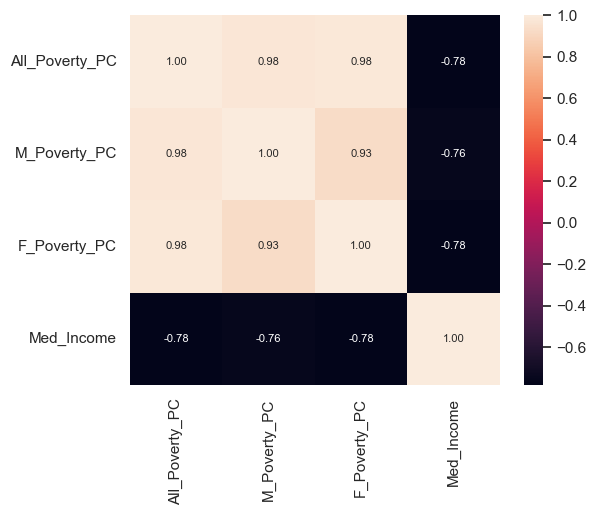

In [40]:
# SOL

# Para pintar la matriz de collelación:
sns.set(font_scale=1)
hm = sns.heatmap(matriz_correlacion, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size':8},
                 yticklabels=cols, xticklabels=cols)
plt.show()

# Creación de modelos y comparación

Crea varios modelos de regresión para estimar la variable  `Mortality_Rate`.
Puedes usar:
* LinearRegression
* GeneralizedLinearRegression
* DecisionTreeRegressor
* IsotonicRegression

Estudia la validez de los distintos modelos.
Ayúdate de los pipelines y la validación cruzada.

------